# Wrangle And Analyse Data Project

In this project, I conducted a data wrangling process through gathering data from a variety of sources and in a variety of formats, assessing its quality and tidiness issues, then structuring and cleaning raw data into the desired format for better analysis and visualizations using Python and its libraries.

# Table of contents
- [Importing Libraries](#import)
- [Part I : Gathering data](#gather)
  - [I-1. Gather data via direct CSV Download](#csv)  
  - [I-2. Gather data via Requests](#requests)
  - [I-3. Gather data via API](#api)
  
- [Part II : Assessing data](#assess)
  - [II-1. Quality issues](#assess_quality)
  - [II-2. Tidiness issues](#assess_tidiness)
  - [II-3. Summary](#assess_summary)
  
- [Part III : Cleaning data](#clean)
  - [III-1. Quality](#clean_quality)
  - [III-2. Tidiness](#clean_tidiness)
  - [III-3. Final Format](#final)
  
- [Part IV : Store](#store)

- [Part V : Analysis and Visualization](#analyze_and_visualize)
  - [V-1. : Rating Analysis](#rating_analysis)
  - [V-2. : Favorites and Retweets Analysis](#Favorites_and_Retweets_Analysis)
  - [V-3. : Stage Analysis](#Stage_Analysis)
  - [V-4. : Dog Breed Analysis](#Dog_Breed_Analysis)

<a id='import'></a>
## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import tweepy
import json
import time
import matplotlib.pyplot as plt
%matplotlib inline

<a id='gather'></a>
## Part I : Gathering Data

<a id='csv'></a>
### I-1. Gather data via direct CSV Download

The WeRateDogs Twitter archive contains basic tweet data.

twitter_archive_enhanced.csv file is downloaded manually and then uploaded to the jupyter notebook

In [2]:
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


`archive` (Twitter archive) columns:
- **tweet_id**: the unique identifier for each tweet
- **in_reply_to_status_id**: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
- **in_reply_to_user_id**: if the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID
- **timestamp**: time when this Tweet was created
- **source**: utility used to post the Tweet, as an HTML-formatted string. e.g. Twitter for Android, Twitter for iPhone, Twitter Web Client
- **text**: actual UTF-8 text of the status update
- **retweeted_status_id**: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s ID
- **retweeted_status_user_id**: if the represented Tweet is a retweet, this field will contain the integer representation of the original Tweet’s author ID
- **retweeted_status_timestamp**: time of retweet
- **expanded_urls**: tweet URL
- **rating_numerator**: numerator of the rating of a dog. Note: ratings almost always greater than 10
- **rating_denominator**: denominator of the rating of a dog. Note: ratings almost always have a denominator of 10
- **name**: name of the dog
- **doggo**: one of the 4 dog "stage"
- **floofer**: one of the 4 dog "stage"
- **pupper**: one of the 4 dog "stage"
- **puppo**: one of the 4 dog "stage"

<a id='requests'></a>
### I-2. Gather data via Requests

'tweet-image-predictions.tsv' is a file downloaded programmatically. It contains the results of a neural network's analysis of tweet images. 

Specifically, it contains predictions as to the image's contents. If it is a dog, then it predicts that dog's breed.

This file (image_predictions.tsv) is hosted on Udacity's servers in the following URL : https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv. <br>
I am going to use the Requests python library to download it programmatically.

In [3]:
# using requests library to download 'image_predictions.tsv' file from
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response
with open('image_predictions.tsv', mode = "wb") as file:
        file.write(response.content)
file

<_io.BufferedWriter name='image_predictions.tsv'>

In [4]:
# read the .tsv file as a dataframe
images = pd.read_csv('image_predictions.tsv', sep='\t')
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


`images` (tweet image predictions) columns:
- **tweet_id**: the unique identifier for each tweet
- **jpg_url**: dog's image URL
- **img_num**: the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images)
- **p1**: algorithm's #1 prediction for the image in the tweet
- **p1_conf**: how confident the algorithm is in its #1 prediction
- **p1_dog**: whether or not the #1 prediction is a breed of dog
- **p2**: algorithm's #2 prediction for the image in the tweet
- **p2_conf**: how confident the algorithm is in its #2 prediction
- **p2_dog**: whether or not the #2 prediction is a breed of dog
- **p3**: algorithm's #3 prediction for the image in the tweet
- **p3_conf**: how confident the algorithm is in its #3 prediction
- **p3_dog**: whether or not the #3 prediction is a breed of dog

<a id='api'></a>
### I-3. Gather data via API

In this part I will to setup access to the twitter api via tweepy.



In [5]:
"""
consumer_key = '*'
consumer_secret = '*'
access_token = '*'
access_secret = '*'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
# Monitoring rate limit and blocking when running out of calls
api = tweepy.API(auth,wait_on_rate_limit= True , wait_on_rate_limit_notify = True)
"""

"\nconsumer_key = '*'\nconsumer_secret = '*'\naccess_token = '*'\naccess_secret = '*'\n\nauth = tweepy.OAuthHandler(consumer_key, consumer_secret)\nauth.set_access_token(access_token, access_secret)\n# Monitoring rate limit and blocking when running out of calls\napi = tweepy.API(auth,wait_on_rate_limit= True , wait_on_rate_limit_notify = True)\n"

In [6]:
# Using the tweet IDs in the Twitter archive, query the Twitter API for each tweet's JSON
"""
start = time.time() # start timer

with open('getstatus_error.txt', 'w') as errfile: 
    valid_ids = 0
    err_ids = 0
    tweet_ids = archive.tweet_id
    with open('tweet_json.txt', 'w', encoding='utf-8') as outfile:
        for i, tweet_id in tweet_ids.iteritems():
            try:
                print("%s# %s" % (str(i+1), tweet_id))
                # Get tweet data using Twitter API
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                json_content = tweet._json
                
                # Write each tweet's JSON data to its own line in a file
                json.dump(json_content, outfile)
                outfile.write('\n')
                valid_ids += 1
            except tweepy.TweepError as e:
                err_ids += 1
                err_str = []
                err_str.append(str(tweet_id))
                err_str.append(': ')
                err_str.append(e.response.json()['errors'][0]['message'])
                err_str.append('\n')
                errfile.write(''.join(err_str))
                print(''.join(err_str))
                continue
        print("%s %s" % ('Valid tweets:', valid_ids))
        print("%s %s" % ('Error tweets:', err_ids))
        
end = time.time() # end timer
print((end - start)/(1000*60))
"""

'\nstart = time.time() # start timer\n\nwith open(\'getstatus_error.txt\', \'w\') as errfile: \n    valid_ids = 0\n    err_ids = 0\n    tweet_ids = archive.tweet_id\n    with open(\'tweet_json.txt\', \'w\', encoding=\'utf-8\') as outfile:\n        for i, tweet_id in tweet_ids.iteritems():\n            try:\n                print("%s# %s" % (str(i+1), tweet_id))\n                # Get tweet data using Twitter API\n                tweet = api.get_status(tweet_id, tweet_mode=\'extended\')\n                json_content = tweet._json\n                \n                # Write each tweet\'s JSON data to its own line in a file\n                json.dump(json_content, outfile)\n                outfile.write(\'\n\')\n                valid_ids += 1\n            except tweepy.TweepError as e:\n                err_ids += 1\n                err_str = []\n                err_str.append(str(tweet_id))\n                err_str.append(\': \')\n                err_str.append(e.response.json()[\'errors\'

In [7]:
# List of dictionaries to read tweet's JSON data line by line and later convert to a DataFrame
df_list = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        status = json.loads(line)
        
        # Append to list of dictionaries
        df_list.append({'tweet_id': status['id'],
                        'retweet_count': status['retweet_count'],
                        'favorite_count': status['favorite_count'],
                        'display_text_range': status['display_text_range']
                       })

# Create a DataFrame with tweet ID, retweet count, favorite count and display_text_range
twitter_counts = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

# Store twitter_counts on disk now that you have retrieved the data.
# It is time consuming to download this from twitter.
twitter_counts.to_csv('twitter_counts.csv', encoding='utf-8', index=False)

In [8]:
# Check and make sure it reads in OK
twitter_counts = pd.read_csv('twitter_counts.csv', encoding='utf-8')
twitter_counts.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8035,37356
1,892177421306343426,5967,32110
2,891815181378084864,3946,24213
3,891689557279858688,8194,40654
4,891327558926688256,8886,38877


`twitter_counts` (tweet status) columns:
- **tweet_id**: the unique identifier for each tweet
- **retweet_count**: number of times this Tweet has been retweeted
- **favorite_count**: indicates approximately how many times this Tweet has been liked by Twitter users

<a id='assess'></a>
## Part II : Assessing data
Data assessing involves examining data quality and tidiness. <br>

<a id='assess_quality'></a>
### II-1. Quality issues

- __Quality issues__ pertain to the content of data. Low quality data is also known as dirty data. There are four dimensions of quality data: <br><br>

  - __Completeness__: do we have all of the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?<br>
  - __Validity__: we have the records, but they’re not valid, i.e., they don’t conform to a defined schema. A schema is a defined set of rules for data. These rules can be real-world constraints (e.g. negative height is impossible) and table-specific constraints (e.g. unique key constraints in tables).<br>
  - __Accuracy__: inaccurate data is wrong data that is valid. It adheres to the defined schema, but it is still incorrect. Example: a patient’s weight that is 5 lbs too heavy because the scale was faulty.<br>
  - __Consistency__: inconsistent data is both valid and accurate, but there are multiple correct ways of referring to the same thing. Consistency, i.e., a standard format, in columns that represent the same data across tables and/or within tables is desired.<br><br>

In [9]:
archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [10]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

- Erroneous datatype : timestamp  and retweeted_status_timestamp should be datetime
- Erroneous datatype : tweet_id should be string
- missing value in these columns : in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls
- Doggo, floofer, pupper, and puppo are categories.
- In 'name', inappropriate name, and missing should be fixed

In [11]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


- some observations have a rating_denominator value different from 10. I suspected it since the minimium value is 0 and the mean value  is 10.45<br>
Lets check those rows :

In [12]:
len(archive.query('rating_denominator != 10'))

23

In [13]:
archive.source.sample(5)

865     <a href="http://twitter.com/download/iphone" r...
2171    <a href="http://twitter.com/download/iphone" r...
1277    <a href="http://twitter.com/download/iphone" r...
878     <a href="http://twitter.com/download/iphone" r...
2262    <a href="http://twitter.com" rel="nofollow">Tw...
Name: source, dtype: object

- unnecessary html tags in *source* column in place of utility name e.g. `<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>`

In [14]:
images.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [15]:
images.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

- ('p1', 'p1_conf', 'p1_dog', 'p2','p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog') Columns names are not informative. Names should be changed to become more informative.


In [16]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


- Erroneous datatype : p1, p2 and p3 should be categorical
- Erroneous datatype :  tweet_id should be string

In [17]:
# Set of images tweet_ids contained in the set of archive tweet_ids 
images.tweet_id.isin(archive.tweet_id).all()

True

In [18]:
# Set of images tweet_ids contained in the set of twitter_counts 
# tweet_ids
images.tweet_id.isin(pd.to_numeric(twitter_counts.tweet_id)).all()

False

- Some tweet_ids contained in <b>images</b> are not included in <b>twitter_counts</b>.</span>

In [19]:
twitter_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2334 entries, 0 to 2333
Data columns (total 3 columns):
tweet_id          2334 non-null int64
retweet_count     2334 non-null int64
favorite_count    2334 non-null int64
dtypes: int64(3)
memory usage: 54.8 KB


- Erroneous datatype : tweet_id should be string

In [20]:
# Let's Compare the lengths of the dataframes to get a sense 
# of which is a subset of the others.
print('  archive tweet count = ' + str(len(archive)))
print('   images tweet count = ' + str(len(images)))
print('twitter_counts tweet count = ' + str(len(twitter_counts)))


  archive tweet count = 2356
   images tweet count = 2075
twitter_counts tweet count = 2334


- tables do not cotain the same number of entries

<a id='assess_tidiness'></a>
### II-2. Tidiness issues

  
- __Tidiness issues__ pertain to the structure of data. These structural problems generally prevent easy analysis. Untidy data is also known as messy data. The requirements for tidy data are:<br><br>

  - Each variable forms a column.
  - Each observation forms a row.
  - Each type of observational unit forms a table.

In [21]:
archive.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


- doggo, floofer, pupper, puppo should be categories of a single variable named "dog_stage"


In [ ]:
twitter_counts.head(2)

- archive and twitter_counts can be consolidated into a single table for which the observational units are tweets. images can be left as-is, because the observational units are images.

<a id='assess_summary'></a>
### II-3. Summary

### Quality Summary
__Archive Table :__ <br>

- Erroneous datatype : timestamp and retweeted_status_timestamp should be datetime
- Erroneous datatype : tweet_id should be string
- Doggo, floofer, pupper, and puppo should be categories
- Denominator is not 10 for 23 tweets
- unnecessary html tags in *source* column in place of utility name

__Images Table :__ <br>
- Erroneous datatype : tweet_id should be string
- ('p1', 'p1_conf', 'p1_dog', 'p2','p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog') Columns names are not informative. Names should be changed to become more informative.
- Erroneous datatype : p1, p2 and p3 should be categorical <br>



__Twitter_counts Table :__ <br>
- Erroneous datatype : tweet_id should be string

__General :__ <br>
- Tables do not contain the same number of entries
- Some tweet_ids contained in <b>images</b> are not included in <b>twitter_counts</b>.</span>

### Tidiness Summary

__Archive Table :__ <br>
- doggo, floofer, pupper, puppo should be categories of a single variable named "dog_stage"

__General :__ <br>
- archive and twitter_counts can be consolidated into a single table for which the observational units are tweets. images can be left as-is, because the observational units are images.

<a id='clean'></a>
## Part III : Cleaning data

Before I start the cleaning process, a good practice is to create a copy of each data set and apply changes on those copies

In [23]:
archive_clean = archive.copy()

In [24]:
images_clean = images.copy()

In [25]:
counts_clean = twitter_counts.copy()

<a id='clean_quality'></a>
### III-1. Quality


#### Define

- Determine the minimum subset of tweets included in <b>archive</b>, <b>images</b>, and <b>twitter_counts</b>.</span><br>
- Drop the rows that aren't part of that subset.</span>

#### Code

In [26]:
print('archive_clean tweet count = ' + str(len(archive_clean)))
print(' images_clean tweet count = ' + str(len(images_clean)))
print('   counts_clean tweet count = ' + str(len(counts_clean)))

archive_clean tweet count = 2356
 images_clean tweet count = 2075
   counts_clean tweet count = 2334


In [27]:
# Reduce set of tweets_to_keep to the set in images_clean
tweets_to_keep = set(images_clean.tweet_id)

counts_clean = counts_clean[counts_clean['tweet_id'].isin(tweets_to_keep)]

# Reduce set of tweets_to_keep to the intersection of the images_clean tweets 
# and the counts_clean tweets
tweets_to_keep = set(counts_clean.tweet_id)

archive_clean = archive_clean[archive_clean['tweet_id'].isin(tweets_to_keep)]
images_clean = images_clean[images_clean['tweet_id'].isin(tweets_to_keep)]

#### Test

In [28]:
print('archive_clean tweet count = ' + str(len(archive_clean)))
print(' images_clean tweet count = ' + str(len(images_clean)))
print('   counts_clean tweet count = ' + str(len(counts_clean)))

archive_clean tweet count = 2062
 images_clean tweet count = 2062
   counts_clean tweet count = 2062


#### Define

- Ensure there are not duplicates of doggo, floofer, pupper, and puppo.<br>
- Create fifth column: <b>none</b>, to indicate the tweet is not classified by dog stage.</span>

#### Code

In [29]:
archive_clean.doggo = archive_clean.doggo.replace('None', 0)
archive_clean.doggo = archive_clean.doggo.replace('doggo', 1)
archive_clean.floofer = archive_clean.floofer.replace('None', 0)
archive_clean.floofer = archive_clean.floofer.replace('floofer', 1)
archive_clean.pupper = archive_clean.pupper.replace('None', 0)
archive_clean.pupper = archive_clean.pupper.replace('pupper', 1)
archive_clean.puppo = archive_clean.puppo.replace('None', 0)
archive_clean.puppo = archive_clean.puppo.replace('puppo', 1)

archive_clean['none'] = 1 - (archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo)
print('Duplicate stage categories = ' + str(archive_clean[archive_clean.none == -1].tweet_id.count()))

Duplicate stage categories = 13


Investigation shows that many of the tweets with duplicate stages contain multiple dogs. Remove all of these as it introduces too many complications for the scope of this project.

In [30]:
duplicate_categories = set(archive_clean[archive_clean.none == -1].tweet_id)

counts_clean = counts_clean[~counts_clean['tweet_id'].isin(duplicate_categories)]
archive_clean = archive_clean[~archive_clean['tweet_id'].isin(duplicate_categories)]
images_clean = images_clean[~images_clean['tweet_id'].isin(duplicate_categories)]

#### Test

In [31]:
print('Duplicate stage categories = ' + str(archive_clean[archive_clean['none'] == -1].tweet_id.count()))
print('\r')
print('archive_clean tweet count = ' + str(len(archive_clean)))
print(' images_clean tweet count = ' + str(len(images_clean)))
print('   counts_clean tweet count = ' + str(len(counts_clean)))


Duplicate stage categories = 0

archive_clean tweet count = 2049
 images_clean tweet count = 2049
   counts_clean tweet count = 2049


#### Define
In archive_clean table :
- Change tweet_id datatype to string
- Change timestamp and retweeted_status_timestamp datatype to datetime


#### Code

In [32]:
archive_clean.tweet_id = archive_clean.tweet_id.astype('str')

In [33]:
archive_clean.timestamp = pd.to_datetime(archive_clean.timestamp)
archive_clean.retweeted_status_id = pd.to_datetime(archive_clean.retweeted_status_id)

#### Test

In [34]:
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2049 non-null object
in_reply_to_status_id         22 non-null float64
in_reply_to_user_id           22 non-null float64
timestamp                     2049 non-null datetime64[ns]
source                        2049 non-null object
text                          2049 non-null object
retweeted_status_id           72 non-null datetime64[ns]
retweeted_status_user_id      72 non-null float64
retweeted_status_timestamp    72 non-null object
expanded_urls                 2049 non-null object
rating_numerator              2049 non-null int64
rating_denominator            2049 non-null int64
name                          2049 non-null object
doggo                         2049 non-null int64
floofer                       2049 non-null int64
pupper                        2049 non-null int64
puppo                         2049 non-null int64
none                   

#### Define
- Replace denominator value with 10 for all rows


#### Code

In [35]:
archive_clean.loc[archive_clean['rating_denominator'] != 10, 'rating_denominator'] = 10


#### Test

In [36]:
len(archive_clean.query('rating_denominator != 10'))

0

#### Define

- Strip all html anchor tags (i.e. `<a..></a>`) in *source* column and retain just the text in between the tags. Convert the datatype from string to categorical.

#### Code

In [37]:
archive_clean.source = archive_clean.source.str.replace(r'<(?:a\b[^>]*>|/a>)', '')
archive_clean.source = archive_clean.source.astype('category')

#### Test

In [38]:
archive_clean.source.sample(5)

1560    Twitter for iPhone
343     Twitter for iPhone
2273    Twitter Web Client
2193    Twitter for iPhone
1561    Twitter for iPhone
Name: source, dtype: category
Categories (3, object): [TweetDeck, Twitter Web Client, Twitter for iPhone]

#### Define

In images_clean table : 
- Change tweet_id datatype to string
- Change p1, p2 and p3 datatype to categorical 

#### Code

In [39]:
images_clean.tweet_id = images_clean.tweet_id.astype('str')
images_clean.p1 = images_clean.p1.astype('category')
images_clean.p2 = images_clean.p2.astype('category')
images_clean.p3 = images_clean.p3.astype('category')


#### Test

In [40]:
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2049 non-null object
jpg_url     2049 non-null object
img_num     2049 non-null int64
p1          2049 non-null category
p1_conf     2049 non-null float64
p1_dog      2049 non-null bool
p2          2049 non-null category
p2_conf     2049 non-null float64
p2_dog      2049 non-null bool
p3          2049 non-null category
p3_conf     2049 non-null float64
p3_dog      2049 non-null bool
dtypes: bool(3), category(3), float64(3), int64(1), object(2)
memory usage: 189.4+ KB


#### Define
- Rename columns ('p1', 'p1_conf', 'p1_dog', 'p2','p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog')


#### Code

In [41]:
images_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [42]:
images_clean.rename(columns = {'p1': 'prediction_1', 
                               'p1_conf': 'confidence_1', 
                               'p1_dog': 'dog_or_not_1',
                               'p2': 'prediction_2', 
                               'p2_conf': 'confidence_2', 
                               'p2_dog': 'dog_or_not_2',
                               'p3': 'prediction_3', 
                               'p3_conf': 'confidence_3', 
                               'p3_dog': 'dog_or_not_3'}, inplace = True)


#### Test

In [43]:
images_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'prediction_1', 'confidence_1',
       'dog_or_not_1', 'prediction_2', 'confidence_2', 'dog_or_not_2',
       'prediction_3', 'confidence_3', 'dog_or_not_3'],
      dtype='object')

#### Define

In Counts_clean table : 
- Change tweet_id datatype to string

#### Code

In [44]:
counts_clean.tweet_id = counts_clean.tweet_id.astype('str')

#### Test

In [45]:
counts_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2049 entries, 0 to 2333
Data columns (total 3 columns):
tweet_id          2049 non-null object
retweet_count     2049 non-null int64
favorite_count    2049 non-null int64
dtypes: int64(2), object(1)
memory usage: 64.0+ KB


<a id='clean_tidiness'></a>
### III-2. Tidiness

#### Define
- Convert doggo, floofer, pupper, puppo, and none to categories in a single column.

#### Code

In [46]:
values = ['doggo', 'floofer', 'pupper', 'puppo', 'none']

ids = [x for x in list(archive_clean.columns) if x not in values]

print(archive_clean.shape)
print(archive_clean.columns)

(2049, 18)
Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'none'],
      dtype='object')


In [47]:
archive_clean = pd.melt(archive_clean, id_vars = ids, value_vars = values, var_name='stage')

print(archive_clean.shape)

(10245, 15)


In [48]:
# subset the dataset to only rows where value is equal to 1
archive_clean = archive_clean[archive_clean.value == 1]
archive_clean.drop('value', axis=1, inplace=True)
archive_clean.reset_index(drop=True, inplace=True);
archive_clean.stage = archive_clean.stage.astype('category')

#### Test

In [49]:
print(archive_clean.shape)
print(archive_clean.columns)
archive_clean.stage.value_counts()

(2049, 14)
Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage'],
      dtype='object')


none       1743
pupper      211
doggo        65
puppo        23
floofer       7
Name: stage, dtype: int64

#### Define

- Use Merge to Consolidate archive and counts into a single table for which the observational units are tweets

#### Code

In [50]:
print(archive_clean.shape)
print(counts_clean.shape)
print(counts_clean.columns)

(2049, 14)
(2049, 3)
Index(['tweet_id', 'retweet_count', 'favorite_count'], dtype='object')


In [51]:
tweets_clean = pd.merge(archive_clean, counts_clean, on='tweet_id')

#### Test

In [52]:
print(tweets_clean.shape)
print(tweets_clean.columns)

(2049, 16)
Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'stage', 'retweet_count',
       'favorite_count'],
      dtype='object')


<a id='final'></a>
### III-3. Final Format


Let's reorder columns for tweets_clean table 

In [53]:
cols = tweets_clean.columns.tolist()
print(cols)

['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator', 'rating_denominator', 'name', 'stage', 'retweet_count', 'favorite_count']


In [54]:
# reordering
cols = cols[0:1] + cols[4:5] + cols[10:12] + cols[13:] + cols[12:13] + cols[5:6] + cols[3:4] + cols[1:3] + cols[6:10]

In [55]:
tweets_clean = tweets_clean[cols]

Drop unusefal columns


In [56]:
tweets_clean.head(2)

,tweet_id,source,rating_numerator,rating_denominator,stage,retweet_count,favorite_count,name,text,timestamp,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls
0,890240255349198849,Twitter for iPhone,14,10,doggo,6985,30811,Cassie,This is Cassie. She is a college pup. Studying...,2017-07-26 15:59:51,NaN,NaN,NaT,NaN,NaN,https://twitter.com/dog_rates/status/890240255...
1,884162670584377345,Twitter for iPhone,12,10,doggo,2836,19663,Yogi,Meet Yogi. He doesn't have any important dog m...,2017-07-09 21:29:42,NaN,NaN,NaT,NaN,NaN,https://twitter.com/dog_rates/status/884162670...


In [57]:
tweets_clean.drop(cols[10:], axis=1, inplace=True)
tweets_clean.drop('rating_denominator', axis=1, inplace=True)

In [58]:
tweets_clean.head(2)

,tweet_id,source,rating_numerator,stage,retweet_count,favorite_count,name,text,timestamp
0,890240255349198849,Twitter for iPhone,14,doggo,6985,30811,Cassie,This is Cassie. She is a college pup. Studying...,2017-07-26 15:59:51
1,884162670584377345,Twitter for iPhone,12,doggo,2836,19663,Yogi,Meet Yogi. He doesn't have any important dog m...,2017-07-09 21:29:42


In [59]:
images_clean.head()

,tweet_id,jpg_url,img_num,prediction_1,confidence_1,dog_or_not_1,prediction_2,confidence_2,dog_or_not_2,prediction_3,confidence_3,dog_or_not_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [60]:
# drop img_num
images_clean.drop('img_num', axis=1, inplace=True)

In [61]:
images_clean.head()

,tweet_id,jpg_url,prediction_1,confidence_1,dog_or_not_1,prediction_2,confidence_2,dog_or_not_2,prediction_3,confidence_3,dog_or_not_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


<a id='store'></a>
### Part IV : Store


In [62]:
tweets_clean.to_csv('twitter_archive_master.csv')

In [63]:
images_clean.to_csv('image_archive_master.csv')

<a id='analyze_and_visualize'></a>
## Part V : Analysis and Visualization


 <a id='rating_analysis'></a>
### V-1. Rating Analysis

In [64]:
tweets_clean.head(2)

,tweet_id,source,rating_numerator,stage,retweet_count,favorite_count,name,text,timestamp
0,890240255349198849,Twitter for iPhone,14,doggo,6985,30811,Cassie,This is Cassie. She is a college pup. Studying...,2017-07-26 15:59:51
1,884162670584377345,Twitter for iPhone,12,doggo,2836,19663,Yogi,Meet Yogi. He doesn't have any important dog m...,2017-07-09 21:29:42


In [65]:
tweets_clean.rating_numerator.describe()

count    2049.000000
mean       12.268424
std        40.937240
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

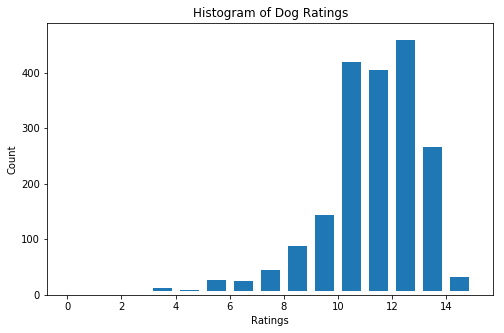

In [66]:
# Ratings
plt.figure(figsize = (8, 5))
plt.xlabel('Ratings')
plt.ylabel('Count')
# since 75% of rating values are below 12 I set bins 
# from 0 to 15 to remove outliers from the plotting
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
plt.hist(x = tweets_clean.rating_numerator, 
         edgecolor='white', linewidth=8, bins = bins)
plt.title('Histogram of Dog Ratings');

The Histogram is Heavily skewed right. It seems that the vast majority of dogs are 10s or above

 <a id='Favorites_and_Retweets_Analysis'></a>
### V-2. Favorites and Retweets Analysis
<br>

In [67]:
tweets_clean[['retweet_count' , 'favorite_count']].describe()

,retweet_count,favorite_count
count,2049.000000,2049.000000
mean,2681.440215,8185.848707
std,4702.329674,12385.854063
min,11.000000,0.000000
25%,575.000000,1564.000000
50%,1270.000000,3600.000000
75%,3096.000000,10252.000000
max,81101.000000,161310.000000


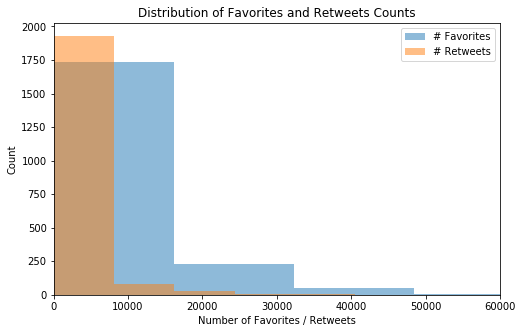

In [68]:
# Histograms of favorites and retweets
plt.figure(figsize=(8, 5))
plt.xlim(0, 60000)
plt.xlabel('Number of Favorites / Retweets')
plt.ylabel('Count')
plt.hist(tweets_clean.favorite_count, alpha=.5, label='# Favorites')
plt.hist(tweets_clean.retweet_count, alpha=.5, label='# Retweets')
plt.title('Distribution of Favorites and Retweets Counts')
plt.legend();

Distribution of favorite_count and retwee_count follow the same pattern, Lets see what happens with correlation

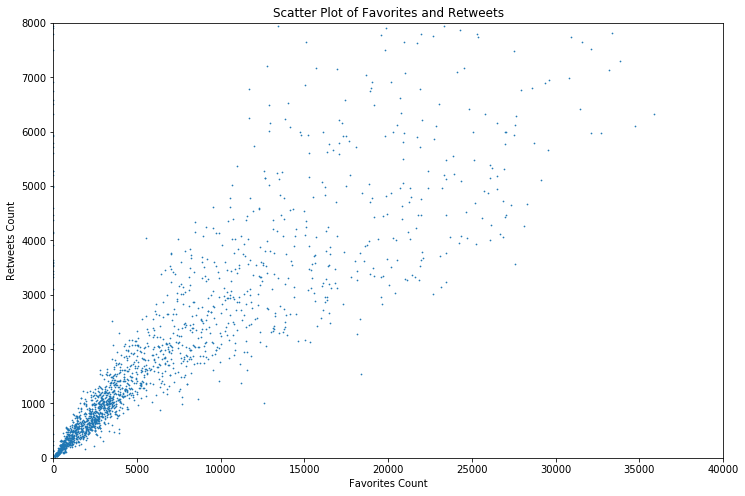

In [69]:
# Scatter plot of favorites and retweets.
plt.figure(figsize=(12, 8))
plt.xlim(0, 40000)
plt.ylim(0, 8000)
plt.xlabel('Favorites Count')
plt.ylabel('Retweets Count')
plt.plot(tweets_clean.favorite_count, 
    tweets_clean.retweet_count, linestyle='', 
     marker='o', markersize=0.7)
plt.title('Scatter Plot of Favorites and Retweets');

Looks like a pretty good correlation . See if log10 will be even better.



In [70]:
# set a copy of dataframe to apply log10
log10 = tweets_clean.copy()
log10 = log10[['favorite_count', 'retweet_count']]
log10['favorite_count'] = tweets_clean.favorite_count.apply(lambda x: np.log10(x))
log10['retweet_count'] = tweets_clean.retweet_count.apply(lambda x: np.log10(x))

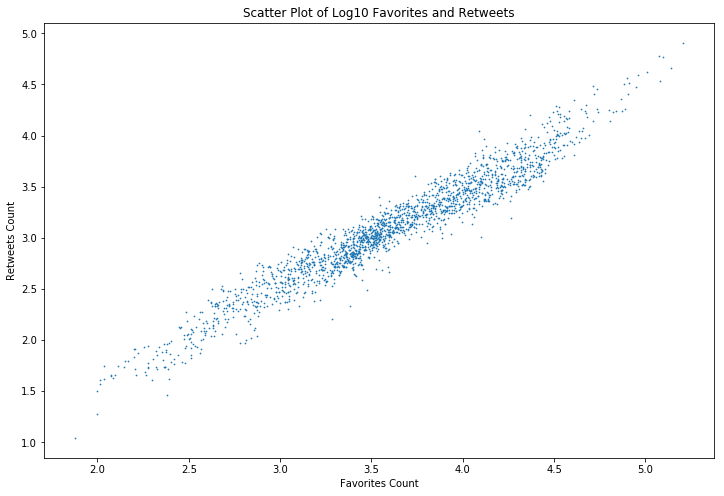

In [71]:
# Log10 scatter plot of favorites and retweets.
plt.figure(figsize=(12, 8))
plt.xlabel('Favorites Count')
plt.ylabel('Retweets Count')
plt.plot(log10.favorite_count, log10.retweet_count, 
           linestyle='', marker='o', markersize=0.7)
plt.title('Scatter Plot of Log10 Favorites and Retweets');

It make sens : People who favorite seem to almost always retweet.<br>





In [72]:
b

,tweet_id,source,rating_numerator,stage,retweet_count,favorite_count,name,text,timestamp
0,890240255349198849,Twitter for iPhone,14,doggo,6985,30811,Cassie,This is Cassie. She is a college pup. Studying...,2017-07-26 15:59:51
1,884162670584377345,Twitter for iPhone,12,doggo,2836,19663,Yogi,Meet Yogi. He doesn't have any important dog m...,2017-07-09 21:29:42


Let's analyze retweets and favorites by month and days

In [73]:
# make a copy of the dataframe
date_df = tweets_clean.copy()
date_df = date_df[['timestamp' , 'retweet_count' , 'favorite_count' , 'source']]
# creatre 'month' column and 'day' column
date_df['month'] = date_df.timestamp.dt.month
date_df['day'] = date_df.timestamp.dt.weekday_name
# a sample from the dataset
date_df.head()

,timestamp,retweet_count,favorite_count,source,month,day
0,2017-07-26 15:59:51,6985,30811,Twitter for iPhone,7,Wednesday
1,2017-07-09 21:29:42,2836,19663,Twitter for iPhone,7,Sunday
2,2017-06-09 00:02:31,5178,26475,Twitter for iPhone,6,Friday
3,2017-06-04 23:56:03,3330,19603,Twitter for iPhone,6,Sunday
4,2017-05-30 16:49:31,3038,15590,Twitter for iPhone,5,Tuesday


In [74]:
# total number of favorites and retweets by month
month_df = date_df.groupby('month').sum()
month_df

,retweet_count,favorite_count
month,,
1,737840,1872577
2,440095,1561341
3,391819,1385230
4,277911,1084933
5,404457,1504202
6,584471,1998600
7,585768,2080741
8,238185,648518
9,259059,676471


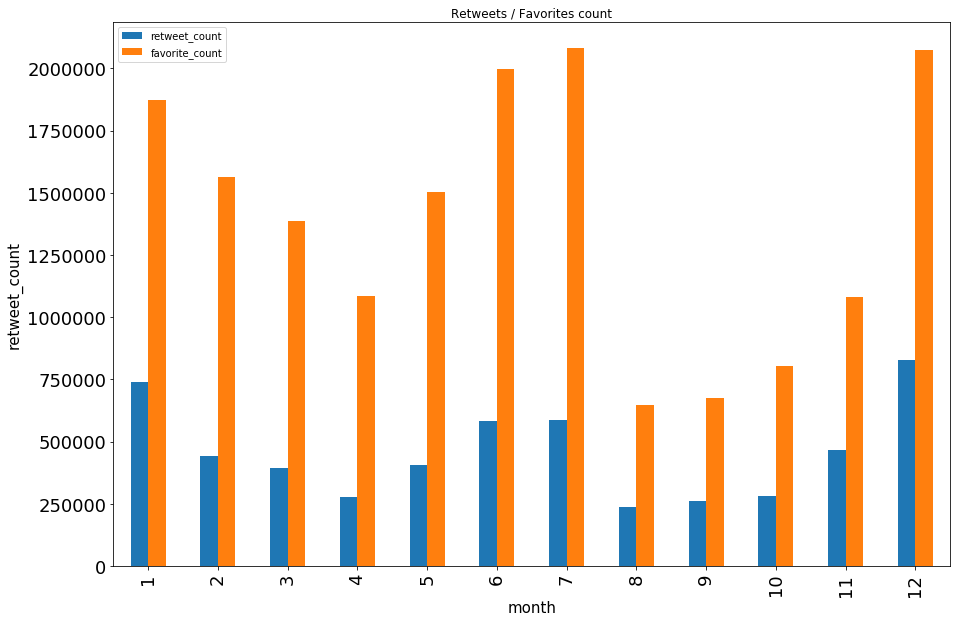

In [75]:
# plot barchart
ax = month_df[['retweet_count','favorite_count']].plot(kind='bar', title ="Retweets / Favorites count", figsize=(15, 10), legend=True, fontsize=18)
ax.set_xlabel("month", fontsize=15)
ax.set_ylabel("retweet_count", fontsize=15)
plt.show()

The Highest number of retweets were in January and december. <br>
The Highest number of favorites were in july and december

In [76]:
# total number of favorites and retweets by day
day_df = date_df.groupby('day').sum()
day_df = day_df[['retweet_count' , 'favorite_count']]
day_df

,retweet_count,favorite_count
day,,
Friday,807731,2356818
Monday,844869,2631775
Saturday,714599,2170158
Sunday,676108,2145896
Thursday,675085,2125992
Tuesday,806253,2570799
Wednesday,969626,2771366


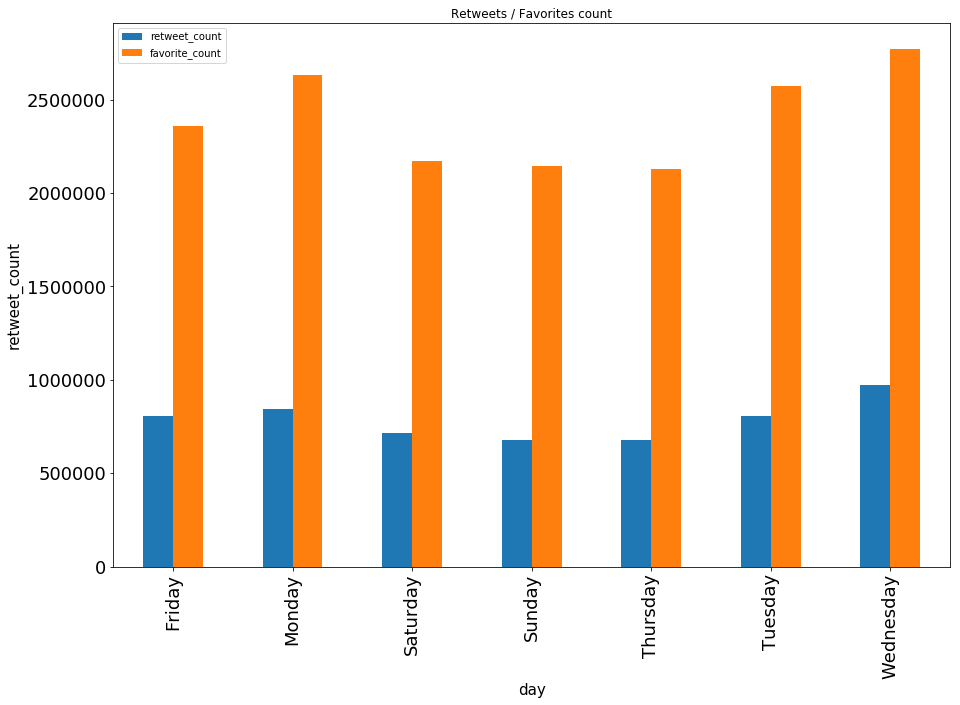

In [77]:
# plot barchart
ax = day_df[['retweet_count','favorite_count']].plot(kind='bar', title ="Retweets / Favorites count", figsize=(15, 10), legend=True, fontsize=18)
ax.set_xlabel("day", fontsize=15)
ax.set_ylabel("retweet_count", fontsize=15)
plt.show()

The Highest number of retweets and favorites both were on Wednesday. <br>

 <a id='Stage_Analysis'></a>
### V-3. Stage Analysis
<br>
What is the dog stage which received the largest number of retweets and favorites in average ?

In [78]:
tweets_clean.head(2)

,tweet_id,source,rating_numerator,stage,retweet_count,favorite_count,name,text,timestamp
0,890240255349198849,Twitter for iPhone,14,doggo,6985,30811,Cassie,This is Cassie. She is a college pup. Studying...,2017-07-26 15:59:51
1,884162670584377345,Twitter for iPhone,12,doggo,2836,19663,Yogi,Meet Yogi. He doesn't have any important dog m...,2017-07-09 21:29:42


In [79]:
stage_df = tweets_clean.groupby('stage').mean()
stage_df

,rating_numerator,retweet_count,favorite_count
stage,,,
doggo,11.938462,7479.846154,18564.261538
floofer,12.000000,4543.428571,12440.571429
none,12.468158,2501.477338,7809.954102
pupper,10.758294,2263.336493,6614.582938
puppo,12.000000,6027.739130,20461.565217


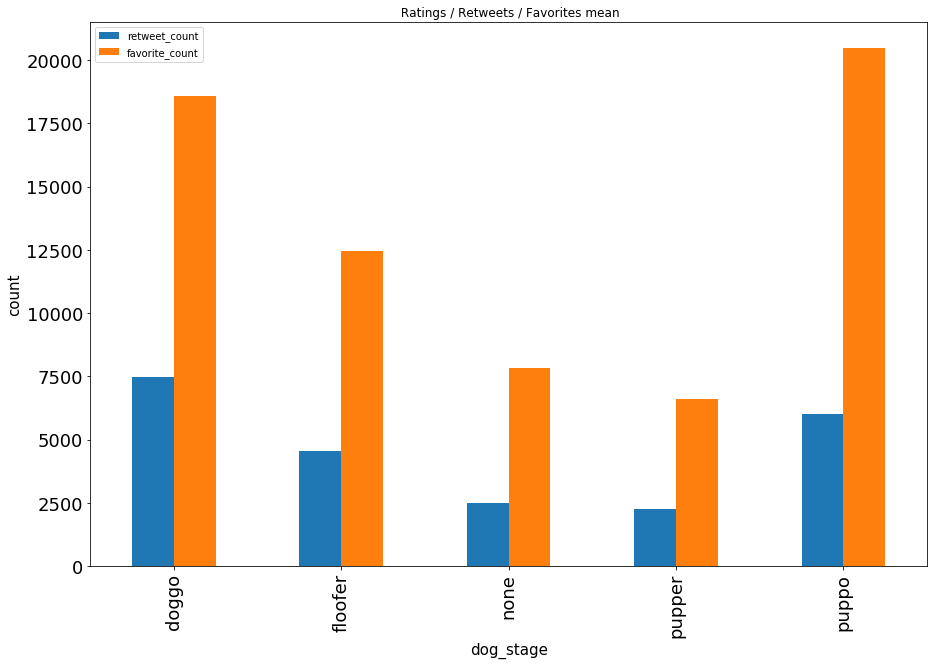

In [114]:
ax = stage_df[['retweet_count' , 'favorite_count']].plot(kind='bar', title =" Ratings / Retweets / Favorites mean", figsize=(15, 10), legend=True, fontsize=18)
ax.set_xlabel("dog_stage", fontsize=15)
ax.set_ylabel("count", fontsize=15)
plt.show()

'puppo' and 'doggo' received the largest number of retweets and favorites in average

 <a id='Dog_Breed_Analysis'></a>
### V-4. Dog Breed Analysis
<br>

In [116]:
images_clean.head(2)

,tweet_id,jpg_url,prediction_1,confidence_1,dog_or_not_1,prediction_2,confidence_2,dog_or_not_2,prediction_3,confidence_3,dog_or_not_3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


In [117]:
# create a copy of images_clean and subset to useful columns
images_merge = images_clean.copy()
images_merge = images_merge[['tweet_id' ,'prediction_1' ,'confidence_1', 'dog_or_not_1']]
images_merge.shape

(2049, 4)

In [118]:
# create a copy of tweets_clean and subset to useful columns
tweets_merge = tweets_clean.copy()
tweets_merge = tweets_merge[['tweet_id' , 'rating_numerator' , 'retweet_count' , 'favorite_count']]
tweets_merge.shape

(2049, 4)

In [119]:
# merge the datasets
breed_clean = pd.merge(tweets_merge, images_merge, on='tweet_id')
breed_clean.shape

(2049, 7)

In [120]:
breed_clean.head(2)

,tweet_id,rating_numerator,retweet_count,favorite_count,prediction_1,confidence_1,dog_or_not_1
0,890240255349198849,14,6985,30811,Pembroke,0.511319,True
1,884162670584377345,12,2836,19663,German_shepherd,0.707046,True


In [121]:
# Use a mask to select only rows corresponding to dogs
breed_clean = breed_clean[breed_clean['dog_or_not_1'] == True]

Lets figure out which breeds get favorited the most.


In [122]:
breed_fav = breed_clean.groupby('prediction_1').sum().reset_index()
breed_fav = breed_fav[['prediction_1', 'favorite_count']]
breed_fav = breed_fav.sort_values('favorite_count', ascending = False)[0:15]
breed_fav

,prediction_1,favorite_count
185,golden_retriever,1551172
44,Labrador_retriever,1016135
58,Pembroke,956833
22,Chihuahua,663820
64,Samoyed,494418
31,French_bulldog,450163
137,chow,391403
285,pug,301048
141,cocker_spaniel,297183
59,Pomeranian,292533


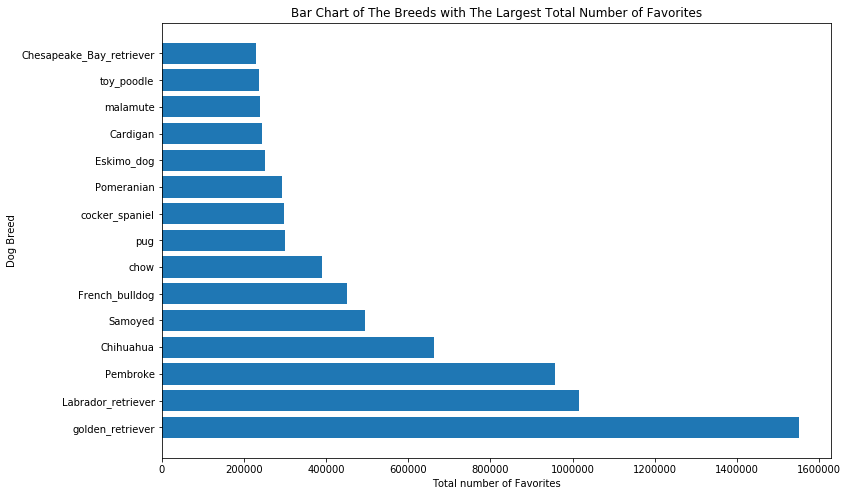

In [123]:
# Bar graph of most 'favorites' breed.
plt.figure(figsize=(12, 8))
plt.barh(range(len(breed_fav.prediction_1)), breed_fav.favorite_count) 
plt.yticks(range(len(breed_fav.prediction_1)),breed_fav.prediction_1)
plt.xlabel('Total number of Favorites')
plt.ylabel('Dog Breed')
plt.title('Bar Chart of The Breeds with The Largest Total Number of Favorites');

The __Golden_retriever__ is the breed that have the largest number of favorites, followed by the __Labrador_retriever__ and __Pembroke__



In [131]:
breed_rate = breed_clean.groupby('prediction_1').mean().reset_index()
breed_rate = breed_rate[['prediction_1', 'rating_numerator']]
breed_rate = breed_rate.sort_values('rating_numerator', ascending = False)[0:15]
breed_rate

,prediction_1,rating_numerator
140,clumber,27.000000
319,soft-coated_wheaten_terrier,25.454545
78,West_Highland_white_terrier,15.642857
36,Great_Pyrenees,14.928571
116,borzoi,14.444444
44,Labrador_retriever,13.814433
70,Siberian_husky,13.250000
185,golden_retriever,13.145833
59,Pomeranian,12.868421
63,Saluki,12.500000


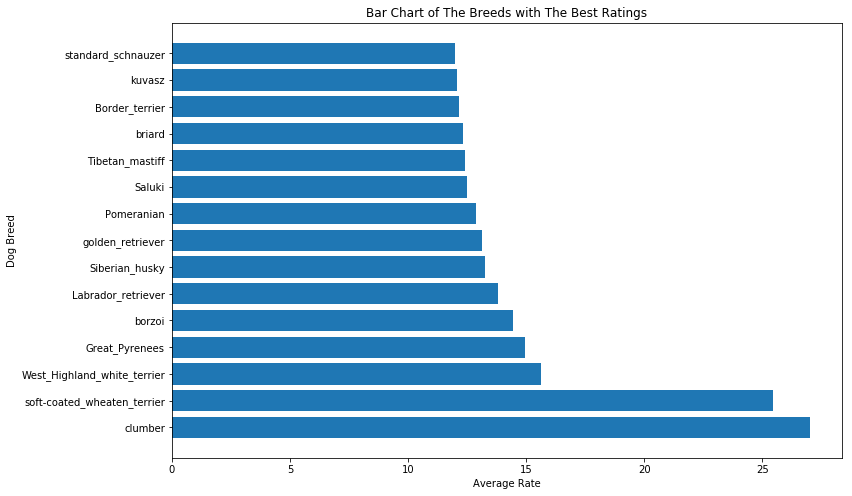

In [132]:
# Bar graph of best rated breeds.
plt.figure(figsize=(12, 8))
plt.barh(range(len(breed_rate.prediction_1)), breed_rate.rating_numerator) 
plt.yticks(range(len(breed_rate.prediction_1)),breed_rate.prediction_1)
plt.xlabel('Average Rate')
plt.ylabel('Dog Breed')
plt.title('Bar Chart of The Breeds with The Best Ratings');

The __Dumber__ and the __Soft_coated_wheatern_terrier__ are the breeds with the best ratings ( above 25 in avergae).  